# 분석 개요
- 이전 RFM 기반 고객 세그먼테이션을 진행하는데 있어, 세그먼트가 너무 많아 해석 및 마케팅 전략을 수립하는데 비효율적으로 느껴져 핵심적인 세그먼트로 줄일 필요성을 느낌
    - 이전 RFM 조합 가능한 경우의 수는 46 종류, 도출한 세그먼트 수는 10개
- 이를 위해 세그먼트 수를 줄이기로 판단, 클러스터링 알고리즘을 활용하여 보다 효율적인 세그먼트 수를 도출하고자 함
- 전반적인 EDA 결과 거래 건 수가 매출에 생각보다 큰 영향을 주지 않은 것을 바탕으로 RFM 요소의 중요도를 고려하여 가중치를 조절할 수 있음
- 이를 통해 고객 세그먼트를 재구성하고, 매출 지표 개선을 위한 마케팅 전략을 수립하고자 함

**왜 RFM 기법을 사용했는지**
- RFM 기법을 활용하면 고객의 구매 행동에 따른 특성과 같은 고객 관점에서의 매출이나 인사이트를 확인할 수 있음
- 세그먼트별로 나누어 매출을 증대시킬 수 있는 맞춤형 마케팅 전략을 수립하고자함

#### Setup

> 기본 라이브러리, 시각화 설정

In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')

# set style
plt.style.use('seaborn-whitegrid')  # Notebook
# plt.style.use('seaborn-v0_8-whitegrid') # Desktop
sns.set_theme(style="whitegrid", palette="pastel")  # Seaborn 스타일 설정

# Matplotlib 설정
plt.rcParams['figure.figsize'] = (5, 5)  # 기본 그래프 크기
plt.rcParams['font.size'] = 12  # 기본 폰트 크기
plt.rcParams['axes.titlesize'] = 15  # 제목 폰트 크기
plt.rcParams['axes.labelsize'] = 12  # 축 레이블 크기
plt.rcParams['xtick.labelsize'] = 10  # x축 틱 크기
plt.rcParams['ytick.labelsize'] = 10  # y축 틱 크기
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 한글 폰트 설정 (한글 데이터 포함 시)
import platform
if platform.system() == "Windows":
    plt.rcParams['font.family'] = 'Malgun Gothic'

# Seaborn 추가 설정
sns.set_context("notebook", font_scale=1.2)  # Seaborn 폰트 크기 조정
sns.set_palette("Set2")  # 기본 색상 팔레트 설정

> 데이터셋

In [3]:
customer = pd.read_csv('raw/Customer_info.csv') # 고객 정보
discount = pd.read_csv('raw/Discount_info.csv') # 할인 정보
marketing = pd.read_csv('raw/Marketing_info.csv') # 마케팅 정보
onlinesales = pd.read_csv('raw/Onlinesales_info.csv') # 온라인거래 정보
tax = pd.read_csv('raw/Tax_info.csv') # 세금 정보

> 데이터전처리

In [4]:
# dtypes : object -> datetime
onlinesales['거래날짜'] = pd.to_datetime(onlinesales['거래날짜'])
marketing['날짜'] = pd.to_datetime(marketing['날짜'])
marketing['월'] = marketing['날짜'].dt.month

# 총 금액 : 수량 * 평균금액
onlinesales['총 금액'] = onlinesales['수량'] * onlinesales['평균금액']

# 거래 월(이름) 생성
onlinesales['거래월'] = onlinesales['거래날짜'].dt.month_name().str[:3]

# 거래 정보 기준으로 고객, 할인, 세금 정보 병합
onlinesales = pd.merge(onlinesales, customer, how='left', on='고객ID')
onlinesales = pd.merge(onlinesales, discount, how='left', left_on=['제품카테고리', '거래월'], right_on=['제품카테고리', '월'])
onlinesales = onlinesales.drop(columns='월')
onlinesales = pd.merge(onlinesales, tax, how='left', on='제품카테고리')

# 거래 월 숫자로 변환
onlinesales['거래월'] = onlinesales['거래날짜'].dt.month

# 결측값 치환
onlinesales['쿠폰코드'] = onlinesales['쿠폰코드'].fillna('none')
onlinesales['할인율'] = onlinesales['할인율'].fillna(0)

# 할인적용금액 : 총 금액 * (1 - 할인율 / 100) - 쿠폰상태 == 'Used' 인 거래에 한 해서서
onlinesales['할인적용금액'] = onlinesales.apply(lambda x: x['총 금액'] * (1 - x['할인율'] / 100) if x['쿠폰상태'] == 'Used' else x['수량'] * x['평균금액'], axis=1)

# 총 지불금액 : 할인적용금액 * (1+GST) + 배송료료
onlinesales['총 지불금액'] = onlinesales['할인적용금액'] * (1 + onlinesales['GST']) + onlinesales['배송료']

onlinesales.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총 금액,거래월,성별,고객지역,가입기간,쿠폰코드,할인율,GST,할인적용금액,총 지불금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1,남,Chicago,12,ELEC10,10.0,0.10,138.339,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1,남,Chicago,12,ELEC10,10.0,0.10,138.339,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,2.05,1,남,Chicago,12,OFF10,10.0,0.10,1.845,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,87.65,1,남,Chicago,12,SALE10,10.0,0.18,87.650,109.9270
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,16.50,1,남,Chicago,12,AIO10,10.0,0.18,14.850,24.0230


### RFM 생성

- Recency: 얼마나 최근에 구매했는가
    - 마지막 거래날짜(2019-12-31) 기준 고객ID 별 가장 마지막 거래일 차이
- Frequency: 얼마나 자주 구매했는가
    - 고객ID 별 주문 건 수
- Monetary: 얼마나 많은 금액을 지불했는가
    - 고객ID 별 총 지불 금액

In [5]:
# Recency
r = onlinesales[['고객ID', '거래날짜']].drop_duplicates(subset=['고객ID'], keep='last')
r['거래날짜'] = abs(r.거래날짜 - pd.to_datetime("2019-12-31")).dt.days

# Frequency, Monetary
f_m = onlinesales.groupby('고객ID').agg({'거래ID': 'nunique', '총 지불금액': 'sum'}).reset_index()
f_m['총 지불금액'] = f_m['총 지불금액'].round(2)

# RFM 테이블 생성
rfm = pd.merge(r, f_m, how='inner', on='고객ID')
rfm.columns = ['고객ID', 'Recency', 'Frequency', 'Monetary']
rfm

,고객ID,Recency,Frequency,Monetary
0,USER_0345,364,1,7.96
1,USER_0922,363,5,988.13
2,USER_1421,363,12,2054.29
3,USER_1249,363,5,650.55
4,USER_0954,363,8,2281.19
...,...,...,...,...
1463,USER_0563,0,289,66004.54
1464,USER_0167,0,14,3286.16
1465,USER_0845,0,3,835.90
1466,USER_0504,0,6,1183.14


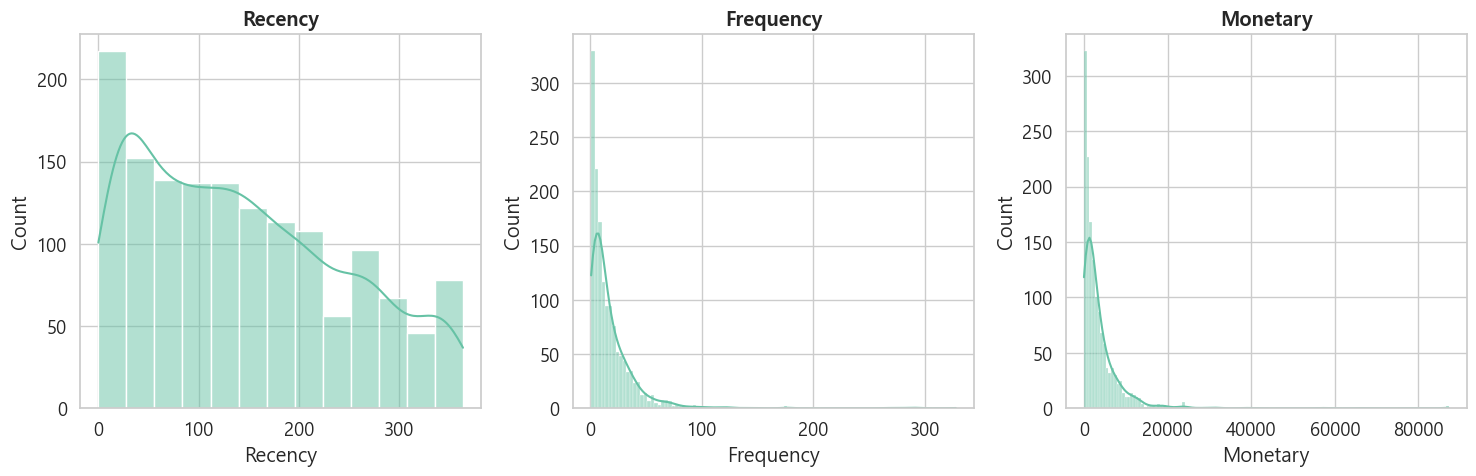

In [6]:
# RFM 분포 히스토그램 시각화
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    sns.histplot(rfm[col], kde=True, ax=ax[i])
    ax[i].set_title(col, fontweight='bold')
plt.tight_layout()
plt.show()

- 각 RFM 이 정규분포를 띄고있지 않음
    - IQR 활용 robust scailing 후 RFM 점수화 진행

> Data Scailing

In [7]:
from sklearn.preprocessing import RobustScaler

rfm_scaled = rfm.copy()
rfm_scaled.drop('고객ID', axis=1, inplace=True)

# IQR 활용 Robust Scailing
for col in ['Recency', 'Frequency', 'Monetary']:
    scaler = RobustScaler()
    rfm_scaled[col] = scaler.fit_transform(rfm_scaled[[col]])

In [8]:
rfm_scaled.describe()

,Recency,Frequency,Monetary
count,1468.000000,1468.000000,1468.000000
mean,0.080559,0.396723,0.448671
std,0.617800,1.387579,1.575303
min,-0.793939,-0.555556,-0.540174
25%,-0.460606,-0.333333,-0.330806
50%,0.000000,0.000000,0.000000
75%,0.539394,0.666667,0.669194
max,1.412121,17.611111,22.955357


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# 정규화를 통한 RFM 점수화(0~100)
rfm['Score'] = rfm_scaled['Recency'] + rfm_scaled['Frequency'] + rfm_scaled['Monetary']
rfm['Score'] = scaler.fit_transform(rfm[['Score']])
rfm['Score'] = round(rfm['Score'] * 100, 1)

In [10]:
rfm['Score'].describe().round(2)

count    1468.00
mean        6.49
std         6.77
min         0.00
25%         3.10
50%         4.90
75%         7.70
max       100.00
Name: Score, dtype: float64

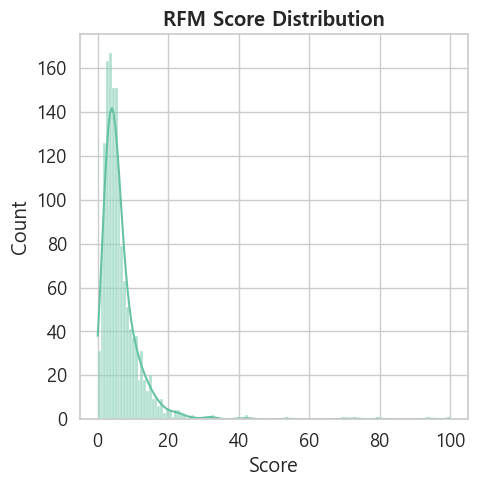

In [11]:
# RFM 점수 분포 확인
sns.histplot(rfm['Score'], kde=True)
plt.title('RFM Score Distribution', fontweight='bold')
plt.show()

> RFM 구성요소 별 상관관계

- RFM 각 요소가 RFM 점수에 영향을 얼마나 주었는지 알아보기 위함

In [12]:
rfm.select_dtypes(exclude='object').corr()

,Recency,Frequency,Monetary,Score
Recency,1.000000,-0.218934,-0.200305,-0.000541
Frequency,-0.218934,1.000000,0.952091,0.961910
Monetary,-0.200305,0.952091,1.000000,0.969109
Score,-0.000541,0.961910,0.969109,1.000000


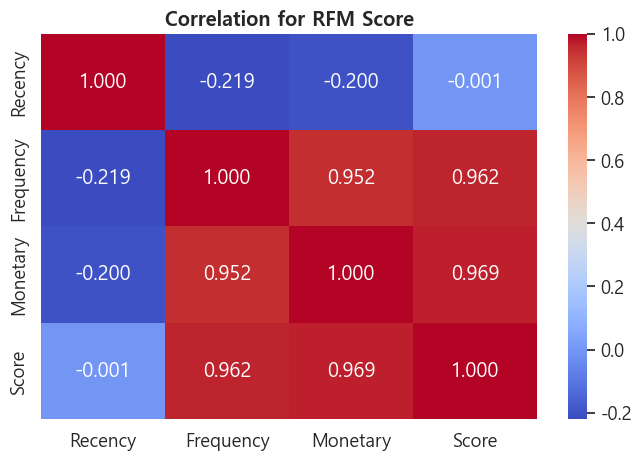

In [13]:
plt.figure(figsize=(8, 5))
sns.heatmap(rfm.select_dtypes(exclude='object').corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation for RFM Score', fontweight='bold')
plt.show()

In [14]:
corr_df = pd.DataFrame(rfm.select_dtypes(exclude='object').corr()['Score'].drop('Score'))
corr_df

,Score
Recency,-0.000541
Frequency,0.961910
Monetary,0.969109


In [15]:
round(corr_df / corr_df.Score.sum(), 2)

,Score
Recency,-0.0
Frequency,0.5
Monetary,0.5


- 상관계수를 통한 상관관계를 확인하여 RFM 각 요소의 독립성을 확인하여 가중치 조정에 활용할 수 있을지?

**Recency**
- 상관계수가 0에 가까워 독립적인 상관관계를 나타내고있어 높은 가중치를 부여할 수 있음
- 고객 최근활동이 중요한 경우 더 높은 가중치를 부여할 수 있을 것

**Frequency, Monetary**
- Frequency와 Monetary는 매우 높은 유사한 상관관계를 나타내고 있어 두 요소의 가중치를 낮출 필요가 있어보임
- 매출 증대가 중요한 경우 Monetary에 더 높은 가중치를 부여하는 방법을 고려

**가중치 조정 목표**
- 가중치를 조정한 후 클러스터링을 통한 고객 세분화 결과가 어떻게 달라지는지 반복적으로 실험 및 검증할 필요가 있을듯

### RFM 기반 고객 Clustering
- 가장 일반적이고 간단해 널리 사용되는 클러스터링 알고리즘 중 하나인 K-Means 활용용
- Elbow Method를 통해 최적의 클러스터 수를 탐색하고, 이를 바탕으로 고객 세그먼트를 분류

> Elbow Method

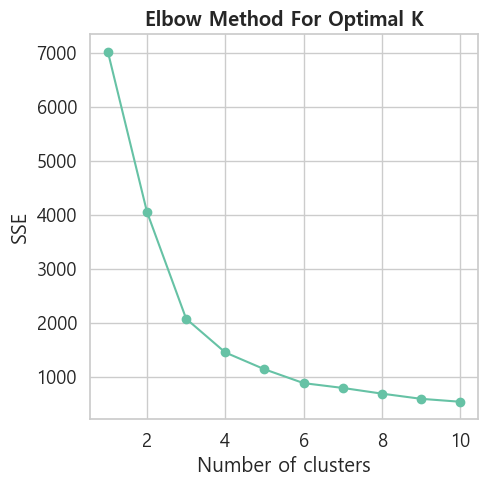

In [16]:
# 최적 클러스터 수 탐색
from sklearn.cluster import KMeans

sse = []    # Sum of Squared Errors
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Elbow 포인트 시각화
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal K', fontweight='bold')
plt.show()

> Silhouette Method

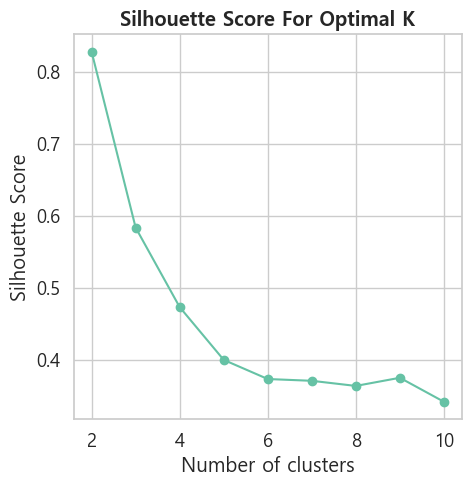

In [17]:
# 실루엣 계수 계산
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))
    
# 실루엣 계수 시각화
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal K', fontweight='bold')
plt.show()

- 클러스터가 2 개 일때 실루엣 계수가 가장 높게 나타났으며, 다음으로 3 개 일때 높게 나타남
- 고객 세그먼트별 분석을 통해 전략을 도출하기 위한 비즈니스 목적으로 클러스터를 나누기 위해 2~3 개 세그먼트는 너무 적어 4~5 개가 보다 적합하다고 판단

> Clustering Simulation by K-Means


Cluster means for k=2
            Recency   Frequency      Monetary      Score
Cluster                                                 
0        145.968078   15.824427   3135.664434   5.859750
1         54.851852  141.777778  32550.606667  39.885185
--------------------------------------------------


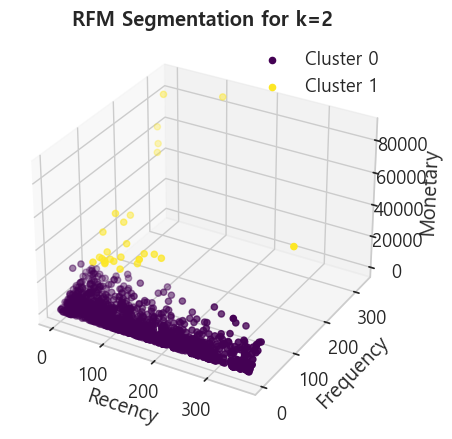


Cluster means for k=3
            Recency   Frequency      Monetary      Score
Cluster                                                 
0        153.738333   10.339167   1902.380167   4.462917
1         60.777778  231.888889  54976.976667  66.133333
2        103.428571   46.861004  10114.709807  13.784170
--------------------------------------------------


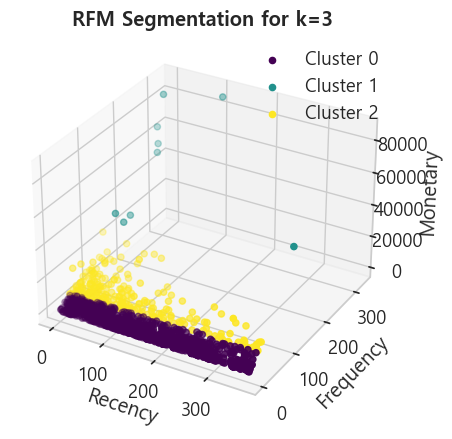


Cluster means for k=4
            Recency   Frequency      Monetary      Score
Cluster                                                 
0        160.161417    7.866142   1401.898228   3.910728
1         74.144737   73.513158  16259.070000  20.789474
2        116.154054   30.886486   6332.173541   9.451892
3         80.833333  270.666667  65739.450000  78.383333
--------------------------------------------------


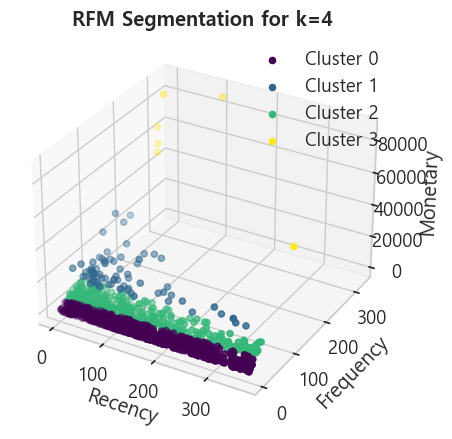


Cluster means for k=5
            Recency   Frequency      Monetary      Score
Cluster                                                 
0        167.399771    6.363116   1111.015258   3.630355
1         99.798658   49.852349  10803.260000  14.563087
2        117.732697   23.436754   4627.423365   7.409785
3         29.200000  289.400000  70779.312000  83.320000
4         60.681818  108.227273  23862.264545  30.013636
--------------------------------------------------


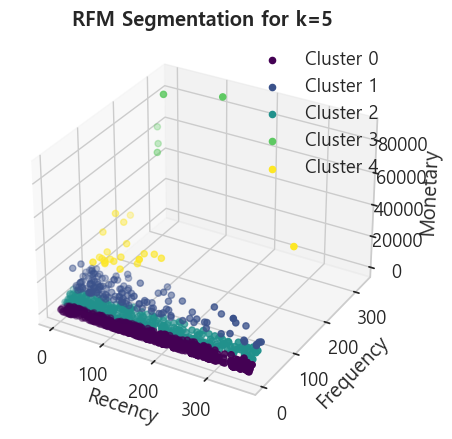

In [18]:
# 클러스터 별 클러스터링 예시
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

    # 클러스터별 평균값 계산
    cluster_means = rfm.groupby('Cluster').mean()
    print(f"\nCluster means for k={k}")
    print(cluster_means)
    print("-" * 50)  # 구분선

    # RFM 기반 클러스터 분포 시각화
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')

    # 클러스터 색상 설정
    colors = plt.cm.viridis(np.linspace(0, 1, k))
    
    # 각 클러스터에 대해 다른 색상과 라벨 지정
    for cluster in range(k):
        cluster_data = rfm[rfm['Cluster'] == cluster]
        ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'],
                   c=[colors[cluster]], label=f'Cluster {cluster}')

    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')
    ax.legend()
    plt.title(f'RFM Segmentation for k={k}', fontweight='bold')
    plt.show()

> Clustering

In [19]:
# K-Means 클러스터링 적용
kmeans = KMeans(n_clusters=4, random_state=42)

# 고객 별 클러스터 레이블 할당
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

In [20]:
pd.concat([rfm['Cluster'].value_counts(), rfm['Cluster'].value_counts(normalize=True)], axis=1, keys=['Count', 'ratio']).sort_index().round(3)

,Count,ratio
0,1016,0.692
1,76,0.052
2,370,0.252
3,6,0.004


In [21]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary', 'Score']].mean().sort_index().round(2)

,Recency,Frequency,Monetary,Score
Cluster,,,,
0,160.16,7.87,1401.90,3.91
1,74.14,73.51,16259.07,20.79
2,116.15,30.89,6332.17,9.45
3,80.83,270.67,65739.45,78.38


- RFM 점수가 높은 순으로 정렬했을 때: Cluster 3 > Cluster 1 > Cluster 2 > Cluster 0
- Cluster 3 의 경우 RFM 점수가 매우 높고 가장 극소수(4%) 고객인 것으로 보아 VIP 고객일 가능성이 높아보임
    - 각 클러스터에 대해 VIP고객, 충성고객, 일반고객, 관심필요고객으로 세그먼트 정의

> 고객 세그먼트 정의

In [22]:
rfm['Segment'] = rfm['Cluster'].map({0:'관심필요고객', 1:'충성고객', 2:'일반고객', 3:'VIP고객'})
rfm.head()

,고객ID,Recency,Frequency,Monetary,Score,Cluster,Segment
0,USER_0345,364,1,7.96,5.0,0,관심필요고객
1,USER_0922,363,5,988.13,6.2,0,관심필요고객
2,USER_1421,363,12,2054.29,7.8,0,관심필요고객
3,USER_1249,363,5,650.55,6.0,0,관심필요고객
4,USER_0954,363,8,2281.19,7.4,0,관심필요고객


In [276]:
rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary', 'Score']].mean().round(2)

,Recency,Frequency,Monetary,Score
Segment,,,,
VIP고객,80.83,270.67,65739.45,78.38
관심필요고객,160.16,7.87,1401.90,3.91
일반고객,116.15,30.89,6332.17,9.45
충성고객,74.14,73.51,16259.07,20.79


**VIP고객**
- 비교적 최근에 거래하였으며, 평균 거래 횟수가 81회, 평균 지불 금액이 약 65,740 달러로 활동성이 압도적으로 높은 고객

**충성고객**
- 가장 최근에 거래하였으며, 평균 거래 횟수가 74회, 평균 지불 금액이 약 16,260 달러로 VIP고객 다음으로 활동성이 높은 고객

**일반고객**
- 두 번째로 고객이 많이 분포해 있으며, 평균 거래 횟수가 31회, 평균 지불 금액이 약 6,330 달러로 가장 일반적인 기준이 되는 고객

**관심필요고객**
- 고객이 가장 많이 분포해 있으며, 평균 거래 횟수가 8회, 평균 지불 금액이 약 1,400 달러로 활동이 매우 저조한 고객

In [23]:
# 온라인 거래 정보에 병합
onlinesales = pd.merge(onlinesales, rfm[['고객ID', 'Segment']], how='left', on='고객ID')
onlinesales.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,총 금액,거래월,성별,고객지역,가입기간,쿠폰코드,할인율,GST,할인적용금액,총 지불금액,Segment
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1,남,Chicago,12,ELEC10,10.0,0.10,138.339,158.6729,VIP고객
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,153.71,1,남,Chicago,12,ELEC10,10.0,0.10,138.339,158.6729,VIP고객
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,2.05,1,남,Chicago,12,OFF10,10.0,0.10,1.845,8.5295,VIP고객
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,87.65,1,남,Chicago,12,SALE10,10.0,0.18,87.650,109.9270,VIP고객
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,16.50,1,남,Chicago,12,AIO10,10.0,0.18,14.850,24.0230,VIP고객


### 세그먼트 별 특성 분석

> 고객 세그먼트 별 비중

In [55]:
pd.concat([rfm['Segment'].value_counts(), rfm['Segment'].value_counts(normalize=True)], keys=['count', 'ratio'], axis=1).round(3)

,count,ratio
관심필요고객,1016,0.692
일반고객,370,0.252
충성고객,76,0.052
VIP고객,6,0.004


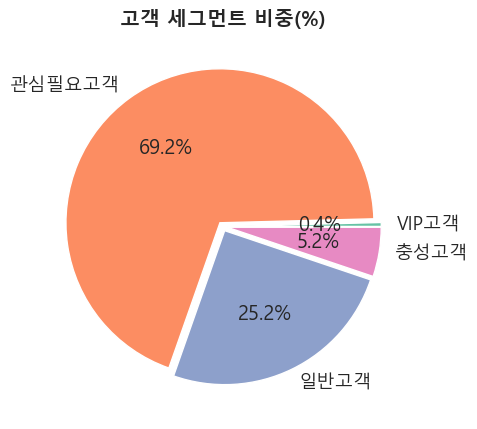

In [121]:
data = rfm.groupby('Segment')['고객ID'].count()

plt.pie(data.values, labels=data.index, autopct='%1.1f%%', explode=(0.03, 0.03, 0.03, 0.03))
plt.title('고객 세그먼트 비중(%)', fontweight='bold')
plt.show()

- 총 1,468명의 고객 중 관심필요고객이 69.2% 로 가장 많고, 다음으로 일반고객이 25.2% 로 대다수를 차지하고 있습니다.
- 극소수 고객인 VIP고객은 0.4% 에 불과하며, 충성고객의 비중은 5.2% 를 차지하고 있습니다.

> 세그먼트 별 평균 가입기간

In [24]:
onlinesales.groupby('Segment')['가입기간'].mean().round(2)

Segment
VIP고객     29.32
관심필요고객    26.44
일반고객      25.64
충성고객      25.74
Name: 가입기간, dtype: float64

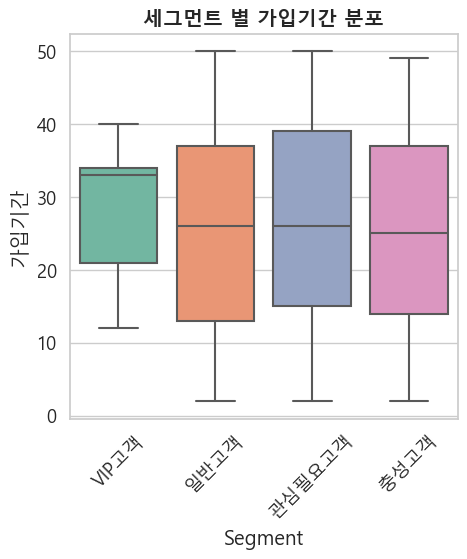

In [25]:
sns.boxplot(x='Segment', y='가입기간', data=onlinesales)
plt.title('세그먼트 별 가입기간 분포', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

- VIP고객층엔 신규고객이 포함되어 있지 않음

> 세그먼트 별 성별 분포

In [26]:
onlinesales.groupby('Segment')['성별'].value_counts(normalize=True).round(2).unstack()

성별,남,여
Segment,,
VIP고객,0.27,0.73
관심필요고객,0.38,0.62
일반고객,0.38,0.62
충성고객,0.40,0.60


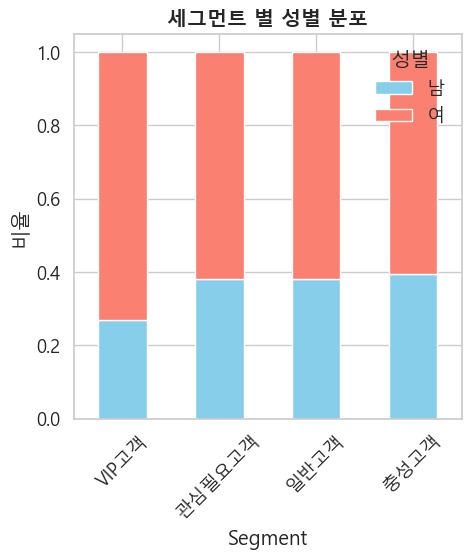

In [124]:
onlinesales.groupby('Segment')['성별'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('세그먼트 별 성별 분포', fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('비율')
plt.show()

- 전체적으로 남성보다 여성 고객 비율이 많았으며, 세그먼트별로 분포를 확인했을 때 특히 여성인 VIP고객이 많았음

> 세그먼트 별 할인 쿠폰 사용 비율

In [28]:
onlinesales.groupby('Segment')['쿠폰상태'].value_counts(normalize=True).unstack().round(2)

쿠폰상태,Clicked,Not Used,Used
Segment,,,
VIP고객,0.50,0.15,0.35
관심필요고객,0.51,0.15,0.34
일반고객,0.51,0.15,0.34
충성고객,0.51,0.16,0.33


- 전체적으로 할인 쿠폰 사용 비율은 동일

> 세그먼트 별 지역 분포

In [29]:
onlinesales.groupby('Segment')['고객지역'].value_counts(normalize=True).unstack().fillna(0).round(2)

고객지역,California,Chicago,New Jersey,New York,Washington DC
Segment,,,,,
VIP고객,0.34,0.66,0.00,0.00,0.00
관심필요고객,0.33,0.30,0.10,0.22,0.05
일반고객,0.29,0.34,0.08,0.23,0.06
충성고객,0.30,0.35,0.09,0.23,0.04


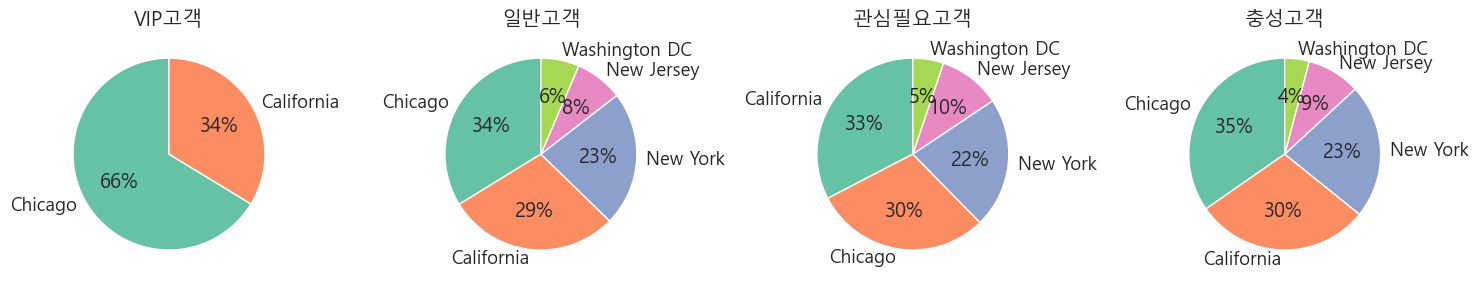

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))

for i, Segment in enumerate(onlinesales['Segment'].unique()):
    data = onlinesales[onlinesales['Segment'] == Segment]['고객지역'].value_counts(normalize=True)
    data.plot(kind='pie', ax=ax[i], autopct='%1.0f%%', startangle=90, title=f'{Segment}')
    ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

- 세그먼트 별 각 지역 분포 비율은 어느정도 비슷한 편으로 보임
- VIP고객의 경우 주로 시카고와 캘리포니아에 분포하고 있음

> 세그먼트별 매출 비중

In [31]:
pd.concat([onlinesales.groupby('Segment')['총 지불금액'].mean(), onlinesales.groupby('Segment')['총 지불금액'].sum()], keys=['평균 매출', '총 매출'], axis=1)

,평균 매출,총 매출
Segment,,
VIP고객,121.402491,3.944367e+05
관심필요고객,88.682436,1.424329e+06
일반고객,104.973527,2.342904e+06
충성고객,109.401443,1.235689e+06


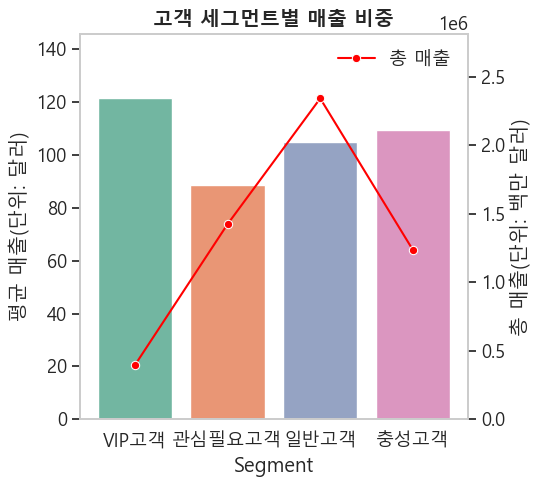

In [48]:
data = pd.concat([onlinesales.groupby('Segment')['총 지불금액'].mean(), onlinesales.groupby('Segment')['총 지불금액'].sum()], keys=['평균 매출', '총 매출'], axis=1).reset_index()

fig, ax1 = plt.subplots(figsize=(5, 5))
sns.barplot(x='Segment', y='평균 매출', data=data, ax=ax1)
ax1.set_ylabel('평균 매출(단위: 달러)')
ax1.set_ylim(0, data['평균 매출'].max()*1.2)
ax1.grid(False)

ax2 = ax1.twinx()
sns.lineplot(x='Segment', y='총 매출', data=data, ax=ax2, color='red', label='총 매출', marker='o')
ax2.set_ylabel('총 매출(단위: 백만 달러)')
ax2.set_ylim(0, data['총 매출'].max()*1.2)
ax2.grid(False)

plt.title('고객 세그먼트별 매출 비중', fontweight='bold')
plt.show()

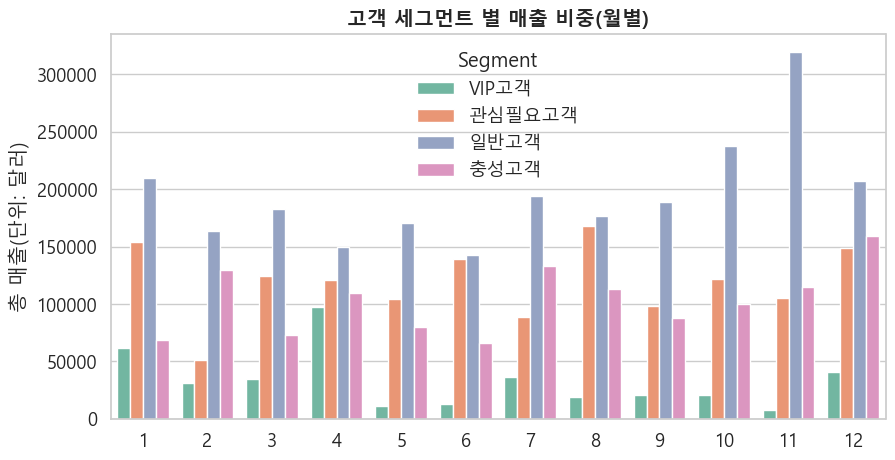

In [47]:
data = onlinesales.groupby(['거래월', 'Segment'])['총 지불금액'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='거래월', y='총 지불금액', hue='Segment', data=data)
plt.xlabel('')
plt.ylabel('총 매출(단위: 달러)')
plt.title('고객 세그먼트 별 매출 비중(월별)', fontweight='bold')
plt.show()

- Monetary 점수가 높은 VIP고객일수록 평균 매출 비중이 높게 나타나고 있음
- 두번째로 고객 수가 많은 일반고객 세그먼트의 매출 비중이 가장 많게 나타났으며, 충성고객의 경우 비교적 소수임에도 불구하고 높은 매출 비중을 차지하고 있음
    - 고객 수가 가장 많은 관심필요고객의 소비 패턴이 전체적으로 소심한 경향으로 나타남
    - 매출 지표를 개선하기 위해서는 관심필요고객을 일반고객으로 전환하는 전략을 세우는 것도 좋겠지만, 극소수 고객층인 충성고객과 VIP고객을 유지하는 전략도 필요해보임

> 고객 세그먼트 별 상위 구매 제품카테고리

In [34]:
onlinesales.groupby('제품카테고리')['총 지불금액'].mean().sort_values(ascending=False)

제품카테고리
Nest-Canada             240.522903
Nest                    236.876102
Nest-USA                194.222918
Notebooks & Journals    163.443683
Google                  125.417210
Gift Cards              122.310967
Backpacks               121.493022
Bags                    102.883429
More Bags                86.372017
Drinkware                78.272169
Headgear                 75.047322
Office                   58.643523
Housewares               57.724580
Fun                      56.215886
Apparel                  45.670816
Accessories              43.586709
Lifestyle                40.516170
Bottles                  37.956398
Android                  25.960960
Waze                     22.214060
Name: 총 지불금액, dtype: float64

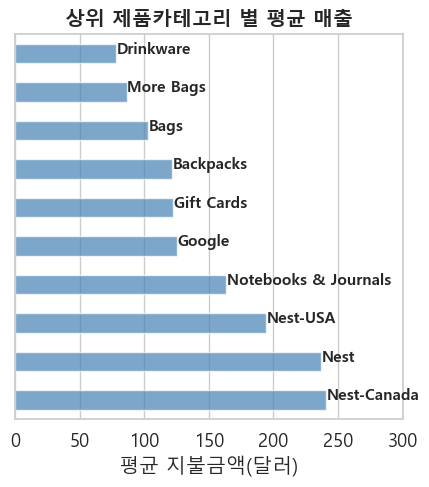

In [36]:
onlinesales.groupby('제품카테고리')['총 지불금액'].mean().sort_values(ascending=False).head(10).plot(kind='barh', figsize=(5, 5), color='steelblue', alpha=0.7)
# 각 막대에 제품카테고리 표시
for i, (idx, val) in enumerate(onlinesales.groupby('제품카테고리')['총 지불금액'].mean().sort_values(ascending=False).head(10).items()):
    plt.text(val + 0.5, i, idx, fontsize=11, fontweight='bold')

plt.title('상위 제품카테고리 별 평균 매출', fontweight='bold')
plt.xlabel('평균 지불금액(달러)')
plt.xlim(0, 300)
plt.ylabel('')
plt.yticks([])
plt.show()

In [37]:
onlinesales.groupby(['Segment', '제품카테고리'])['총 지불금액'].mean().sort_values(ascending=False).groupby('Segment').head(5).unstack(fill_value=0).round(2)

제품카테고리,Notebooks & Journals,Nest-Canada,Nest,Google,Headgear,Nest-USA,Backpacks,Gift Cards,Bags
Segment,,,,,,,,,
VIP고객,288.26,245.87,224.77,239.70,228.15,0.00,0.00,0.00,0.00
관심필요고객,0.00,236.61,230.95,124.99,0.00,190.51,0.00,141.99,0.00
일반고객,128.82,245.96,239.81,0.00,0.00,194.49,144.77,0.00,0.00
충성고객,270.76,229.98,238.47,0.00,0.00,197.87,0.00,0.00,136.65


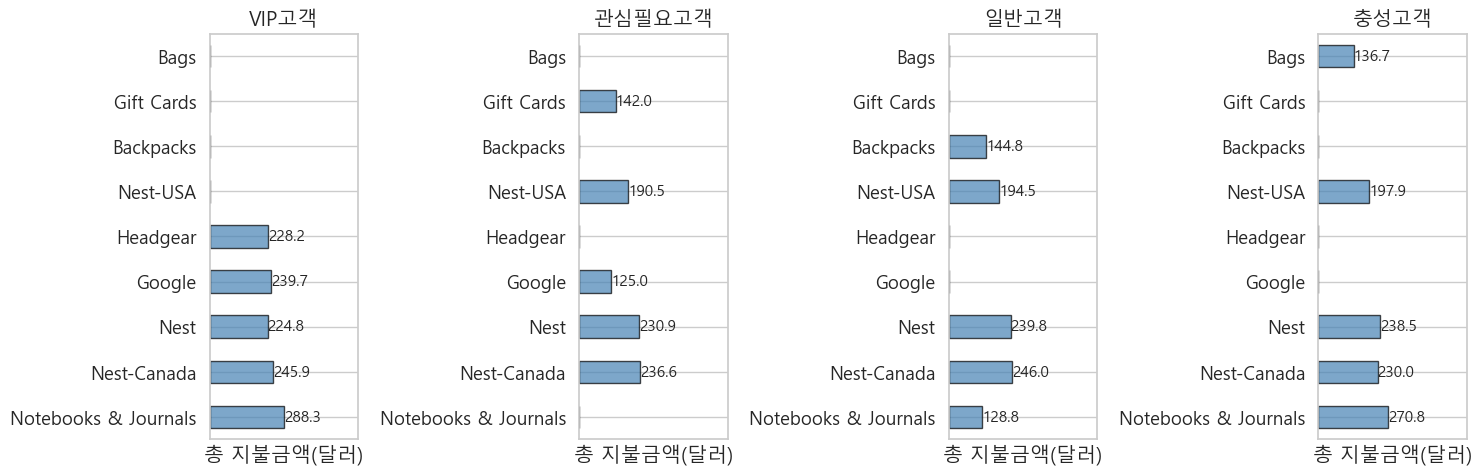

In [38]:
data = onlinesales.groupby(['Segment', '제품카테고리'])['총 지불금액'].mean().sort_values(ascending=False).groupby('Segment').head(5).unstack(fill_value=0).round(2)

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
for i, Segment in enumerate(data.index):
    data.loc[Segment].plot(kind='barh', ax=ax[i], title=f'{Segment}', color='steelblue', edgecolor='black', alpha=0.7)
    # 데이터 레이블 표시(0이 아닌 경우에만 표시)
    for j, value in enumerate(data.loc[Segment]):
        if value != 0:
            ax[i].text(value, j, f'{value:.1f}', ha='left', va='center', fontsize=11)
    ax[i].set_xlabel('총 지불금액(달러)')
    ax[i].set_ylabel('')
    ax[i].set_xticks([])
    ax[i].set_xlim(0, data.max().max() * 2)
plt.tight_layout()
plt.show()

- 세그먼트 별 전체 고객에 대한 매출 비교는 인원이 소수일수록 매출이 높게 나타날 수 밖에 없음
    - 따라서 세그먼트 별 평균 매출(지불금액)로 비교하는 방법을 채채택
- 고객 등급이 높을 수록 인당 총 매출이 높게 발생하며 특히, 관심필요고객층에서 Notebooks & Journals 제품군에 대한 매출이 전혀 발생하지않음

> 고객 세그먼트 별 구매 경향

**재구매율**
- 최초 주문 날짜 이후 또 다른 거래가 발생했을 경우 재구매 고객으로 분류

**구매주기**
- 구매주기: (최근 구매일 - 최초 구매일) / (주문 건 수 - 1)
    - 최초 1회 구매 고객에 대해서는 구매 주기를 최대(364일)로 처리

In [270]:
# 고객 세그먼트별 재구매 횟수
data = onlinesales.groupby(['고객ID', 'Segment'])['거래날짜'].nunique().reset_index()
data.rename(columns={'거래날짜': '재구매수'}, inplace=True)
data['재구매수'] = data['재구매수'] - 1

data['재구매여부'] = np.where(data['재구매수'] == 0, 0, 1)

display(data.head())
print(data.groupby('Segment')['재구매여부'].mean().round(2))

,고객ID,Segment,재구매수,재구매여부
0,USER_0000,관심필요고객,0,0
1,USER_0001,충성고객,2,1
2,USER_0002,관심필요고객,1,1
3,USER_0003,관심필요고객,0,0
4,USER_0004,관심필요고객,0,0


Segment
VIP고객     1.00
관심필요고객    0.36
일반고객      0.78
충성고객      0.96
Name: 재구매여부, dtype: float64


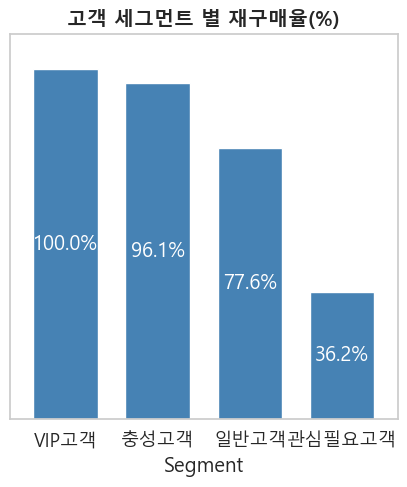

In [271]:
a = data.groupby('Segment')['재구매여부'].mean().sort_values(ascending=False)

a.plot(kind='bar', color='steelblue', width=0.7)
# 퍼센트 표시
for i in range(len(a)):
    plt.text(i, a[i]*0.5, f'{(a[i]*100):.1f}' + '%', ha='center', va='center', color='white')

plt.xticks(rotation=0)
plt.yticks([])
plt.ylim(0, 1.1)
plt.grid(False)

plt.title('고객 세그먼트 별 재구매율(%)', fontweight='bold')
plt.show()

- VIP고객, 충성고객의 경우 100% 가까이 재구매가 이루어짐(Frequency 즉, 구매 횟수가 많을수록 재구매할 가능성이 높기 때문)
- 고객 수가 가장 많은 세그먼트인 관심필요고객의 재구매율은 36.2% 에 불과하며 가장 낮음
    - 프로모션 개선 또는 신규 프로모션 기획 시 관심필요고객 세그먼트의 재구매를 유도하는 전략이 필요한 것으로 보임

In [281]:
data = rfm['Recency'].div(rfm['Frequency'] - 1).replace(np.inf, rfm['Recency'].max()).to_frame('구매주기')
data = pd.concat([rfm, data], axis=1)
display(data.head())
print(f'고객 평균 구매 주기: {data.구매주기.mean():.1f}' ,'\n')
print(data.groupby('Segment')['구매주기'].describe().round(1))

,고객ID,Recency,Frequency,Monetary,Score,Cluster,Segment,구매주기
0,USER_0345,364,1,7.96,5.0,0,관심필요고객,364.000000
1,USER_0922,363,5,988.13,6.2,0,관심필요고객,90.750000
2,USER_1421,363,12,2054.29,7.8,0,관심필요고객,33.000000
3,USER_1249,363,5,650.55,6.0,0,관심필요고객,90.750000
4,USER_0954,363,8,2281.19,7.4,0,관심필요고객,51.857143


고객 평균 구매 주기: 57.0 

          count  mean    std  min   25%   50%   75%    max
Segment                                                   
VIP고객       6.0   0.4    0.8  0.0   0.0   0.1   0.3    1.9
관심필요고객   1016.0  80.5  119.6  0.0  10.1  24.5  71.5  364.0
일반고객      370.0   4.7    7.3  0.0   1.4   2.9   6.1   89.3
충성고객       76.0   1.3    2.0  0.0   0.3   0.7   1.5   13.9


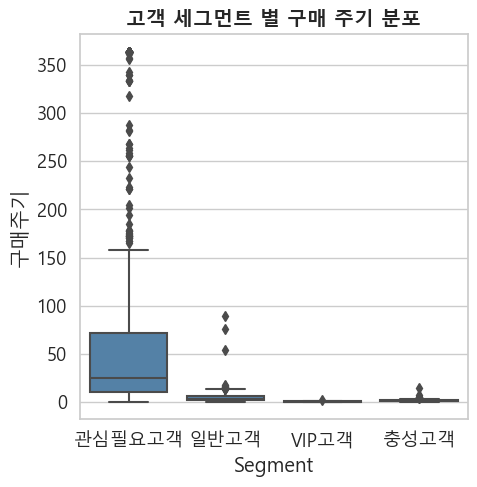

In [273]:
sns.boxplot(data=data, x='Segment', y='구매주기', color='steelblue')

plt.title('고객 세그먼트 별 구매 주기 분포', fontweight='bold')
plt.show()

- 일반고객 세그먼트의 평균 구매 주기는 약 5일
- 최초 1회 구매 즉, 재구매가 이루어지지 않은 고객이 다수 포함된 관심필요고객 세그먼트의 평균 구매주기는 81일로 나타남
- VIP고객과 충성고객 세그먼트는 약 하루에 한 번씩 거래가 이루어져 높은 세그먼트일 수록 구매주기가 매우 짧음